# Tentativa de quebrar CAPTCHA com Python (parte 2)

- [Primeiro vídeo no YouTube](https://www.youtube.com/watch?v=uqHhLTrEU9U)
- [Post no blog explicando o processo](https://mrioqueiroz.com/2020/05/02/continuacao-do-projeto-de-quebra-de-captcha/)

## Preparação do ambiente

- Adicionar novo ambiente no [Anaconda](https://www.anaconda.com/) Navigator para evitar conflito com o ambiente *base*
- Adicionar o canal [`conda-forge`](https://conda-forge.org/) para baixar dependências

### Dependências

- [`Pillow`](https://python-pillow.org/) para leitura das imagens
- [`Tesseract`](https://github.com/tesseract-ocr) para OCR
- [`Pytesseract`](https://pypi.org/project/pytesseract/) *wrapper* para o [`Tesseract`](https://github.com/tesseract-ocr)

## OCR Básico

In [19]:
from PIL import Image
from pytesseract import image_to_string

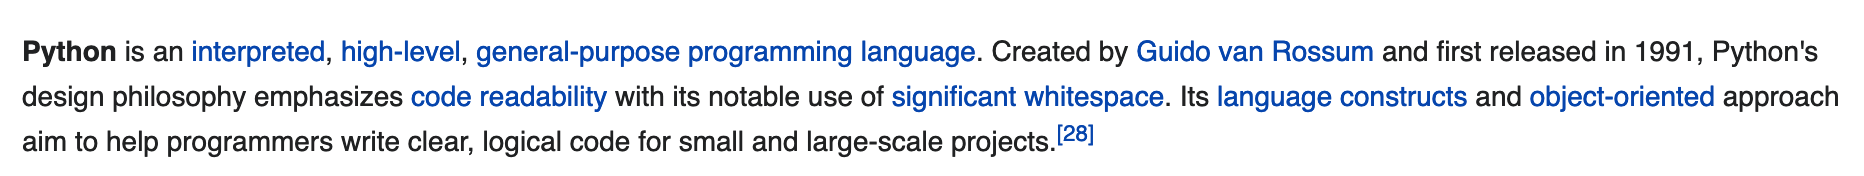

In [20]:
ocr_basico = Image.open("wiki.png")
ocr_basico

In [21]:
image_to_string(ocr_basico)

"Python is an interpreted, high-level, general-purpose programming language. Created by Guido van Rossum and first released in 1991, Python's\ndesign philosophy emphasizes code readability with its notable use of significant whitespace. Its language constructs and object-oriented approach\naim to help programmers write clear, logical code for small and large-scale projects.|28]"

### Tentativa com CAPTCHA

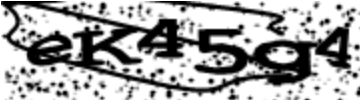

In [22]:
captcha = Image.open("captcha.png")
captcha

In [23]:
image_to_string(captcha)

''

Tendo isso como resultado, precisamos aprender um pouco sobre os parâmetros do Tesseract.

## [Parâmetros do Tesseract](https://github.com/tesseract-ocr/tesseract/blob/master/doc/tesseract.1.asc)

Nesse ponto, vamos fazer com que o OCR se limite a determinados caracteres, no nosso caso letras maiúsculas e minúsculas e números; evitando espaços, caracteres especiais, etc. Faremos isso através da *flag* `-c` nas configurações da função `image_to_string`. Especificaremos também o *layout* de análise utilizado, através da *flag* `--psm`, já que alguns *layouts* retornam resultados melhores que outros.  

Os *layouts* que retornaram melhores resultados foram: `7`, `8`, `9`, `10`, `11` e `13`.

In [24]:
from string import ascii_letters, digits

caracteres_permitidos = ascii_letters + digits

print(caracteres_permitidos)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789


In [25]:
layout_de_analise = 9
image_to_string(captcha,
                config=f"--psm {layout_de_analise} -c tessedit_char_whitelist={caracteres_permitidos}")

'ekAsa4'

Importante notar que, quanto mais *layouts* utilizarmos, mais lento ficará o programa.

In [26]:
psms = [7, 8, 9, 10, 13]

def reconhecer_caracteres(imagem, layout):
    return image_to_string(
        captcha,
        config=f"""--psm {layout} 
        -c tessedit_char_whitelist={caracteres_permitidos}""")

for psm in psms:
    print(f"layout {psm}: {reconhecer_caracteres(captcha, psm)}")

layout 7: eASay4
layout 8: eASay4
layout 9: ekAsa4
layout 10: eASay4
layout 13: eASay4


Transformando o que fizemos acima em uma nova função, temos todos os resultados para cada *layout* armazenados em uma lista:

In [27]:
def armazenar_resultados():
    resultados = []
    for psm in psms:
        resultados.append(reconhecer_caracteres(captcha, psm))
    return resultados

armazenar_resultados()

['eASay4', 'eASay4', 'ekAsa4', 'eASay4', 'eASay4']

Nesse ponto, podemos fazer uma contagem de quantas vezes determinado caractere apareceu em cada um dos índices da *string*:

In [28]:
from collections import Counter

def contar_ocorrencias_de_caracteres(resultados, posicao=0):
    for resultado in resultados:
        mais_comum = [list() for _ in range(len(resultados))]
        for indice, caractere in enumerate(mais_comum):
            mais_comum[indice] = Counter(
                resultados[indice]).most_common()[posicao][0]
    return mais_comum

contar_ocorrencias_de_caracteres(armazenar_resultados(), 3)

['a', 'a', 's', 'a', 'a']

In [29]:
def resultado_final():
    caracteres = [list() for _ in range(6)]
    resultados = armazenar_resultados()
    for posicao in range(6):
        for resultado in resultados:
            for indice, caractere in enumerate(caracteres):
                caractere.append(resultado[indice])
    return caracteres

for c in contar_ocorrencias_de_caracteres(resultado_final()):
    print(c, end="")

eASay4

## Remoção de ruídos

*Neste ponto, é necessário fazer a conversão da imagem para preto e branco. Do contrário, receberemos a `exception` `TypeError: '>' not supported between instances of 'tuple' and 'int'` ao tentar verificar se estamos ou não em um pixel escuro na função abaixo.*

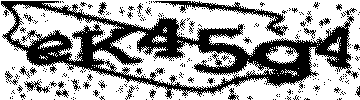

In [30]:
captcha = captcha.convert("1")
captcha

O código abaixo é baseado no projeto [decodeCaptcha](https://github.com/djadmin/decodeCaptcha/) do [djadmin](https://github.com/djadmin). Fiz um [fork](https://github.com/mrioqueiroz/decodeCaptcha) do projeto para que seja possível rodar utilizando Python 3.

In [31]:
def limpar(imagem):
    limite = 1
    largura, altura = imagem.size
    pixels = imagem.load()

    for linha in range(altura):
        for coluna in range(largura):
            if pixels[coluna, linha] > 128:  # Se o pixel for claro, pula os demais passos.
                continue
            escuros = 0
            for pixel in range(coluna, largura):  # Verifica a sequência de pixels do ponto em que estamos até o final.
                if pixels[pixel, linha] < 128:
                    escuros += 1  # Se o pixel for escuro, incrementa o total.
                else:
                    break
            if escuros <= limite:  # Se temos menos pixels escuros que o limite, substitui todos por pixels claros.
                for pixel in range(escuros):
                    pixels[coluna + pixel, linha] = 255
            coluna += escuros  # Pula a sequência que já foi alterada.

    for coluna in range(largura):
        for linha in range(altura):
            if pixels[coluna, linha] > 128:
                continue
            escuros = 0
            for pixel in range(linha, altura):
                if pixels[coluna, pixel] < 128:
                    escuros += 1
                else:
                    break
            if escuros <= limite:
                for pixel in range(escuros):
                    pixels[coluna, linha + pixel] = 255
            linha += escuros

    return imagem

A cada execução da função, a imagem se torna mais clara:

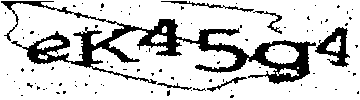

In [32]:
limpar(captcha)

Até um ponto em que conseguimos obter melhores resultados com o OCR:

In [33]:
image_to_string(captcha)

''

processamento 0: 
processamento 1: 
processamento 2: eK4Sg4
processamento 3: ei 5441
processamento 4: | e ee <4]


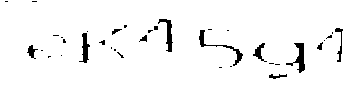

In [34]:
captcha = Image.open("captcha.png").convert("1")

for processamento in range(5):
    print(f"processamento {processamento}: {image_to_string(limpar(captcha))}")

captcha

## Agora reunindo tudo o que fizemos até o momento

Com algumas alterações para facilitar o entendimento, temos o seguinte código:

[['e', 'k', 'A', 'S', 'a', 's'],
 ['e', 'K', '4', '5', '4', '4'],
 ['e', 'K', '4', 'A', '5', 'S'],
 ['e', 'K', 'A', 'S', 'G', '4'],
 ['e', 'K', 'I', 'S', 'g', '4']]
resultado: ekasg4

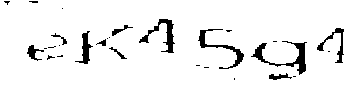

In [35]:
from collections import Counter
from pprint import pprint
from string import ascii_letters, digits

from PIL import Image
from pytesseract import image_to_string


def obter_caracteres(imagem):
    caracteres = [list() for _ in range(6)]
    resultados = tentar_layouts(imagem)
    for posicao in range(6):
        for resultado in resultados:
            for indice, caractere in enumerate(caracteres):
                try:
                    caractere.append(resultado[indice])
                except IndexError:
                    pass
    return caracteres


def tentar_layouts(imagem):
    resultados = []
    layouts = [7, 8, 9, 10, 11, 13]
    for layout in layouts:
        resultados.append(reconhecer_caracteres(imagem, layout))
    return resultados


def reconhecer_caracteres(imagem, layout):
    return image_to_string(
        captcha,
        config=
        f"""--psm {layout} 
        -c tessedit_char_whitelist={ascii_letters + digits}""")


def remover_ruidos(imagem):
    limite = 1
    largura, altura = imagem.size
    pixels = imagem.load()

    for linha in range(altura):
        for coluna in range(largura):
            if pixels[coluna, linha] > 128:
                continue
            escuros = 0
            for pixel in range(coluna, largura):
                if pixels[pixel, linha] < 128:
                    escuros += 1
                else:
                    break
            if escuros <= limite:
                for pixel in range(escuros):
                    pixels[coluna + pixel, linha] = 255
            coluna += escuros

    for coluna in range(largura):
        for linha in range(altura):
            if pixels[coluna, linha] > 128:
                continue
            escuros = 0
            for pixel in range(linha, altura):
                if pixels[coluna, pixel] < 128:
                    escuros += 1
                else:
                    break
            if escuros <= limite:
                for pixel in range(escuros):
                    pixels[coluna, linha + pixel] = 255
            linha += escuros

    return imagem


def resultado(listas):
    print("resultado: ", end="")
    c = [list() for _ in range(6)]
    for i, _ in enumerate(c):
        for lista in listas:
            c[i].append(lista[i].lower())
    for i, _ in enumerate(c):
        for lista in listas:
            c[i] = Counter(c[i]).most_common()[0][0]
    for x in c:
        print(f"{x}", end="")


def contar_caracteres(listas):
    for lista in listas:
        mais_comuns = [list() for _ in range(len(listas))]
        for indice, _ in enumerate(mais_comuns):
            try:
                mais_comuns[indice] = Counter(listas[indice]).most_common()[0][0]
            except IndexError:
                pass
    return mais_comuns


captcha = Image.open("test-01.png").convert("1")
parciais = []
mais_frequentes = []

parciais.append(obter_caracteres(captcha))

for _ in range(4):
    parciais.append(obter_caracteres(remover_ruidos(captcha)))
    
for i in parciais:
    mais_frequentes.append(contar_caracteres(i))
    
pprint(mais_frequentes)
resultado(mais_frequentes)
captcha

Nota-se que a sequência básica é: `abrir imagem -> remover ruidos -> obter caracteres -> contar caracteres`.

### E se começarmos a reforçar os traços?

A função abaixo faz o inverso da função de remover ruídos.

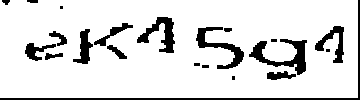

In [36]:
def reforcar_tracos(imagem):
    limite = 1
    largura, altura = imagem.size
    pixels = imagem.load()
    for linha in range(altura):
        for coluna in range(largura):
            if pixels[coluna, linha] < 128:
                continue
            escuros = 0
            for pixel in range(coluna, largura):
                if pixels[pixel, linha] > 128:
                    escuros += 1
                else:
                    break
            if escuros <= limite + 1:  # Reforço maior.
                for pixel in range(escuros):
                    pixels[coluna + pixel, linha] = 0
            coluna += escuros

    for coluna in range(largura):
        for linha in range(altura):
            if pixels[coluna, linha] < 128:
                continue
            escuros = 0
            for pixel in range(linha, altura):
                if pixels[coluna, pixel] > 128:
                    escuros += 1
                else:
                    break
            if escuros <= limite + 1:
                for pixel in range(escuros):
                    pixels[coluna, linha + pixel] = 0
            linha += escuros

    return imagem

reforcar_tracos(captcha)

[['e', 'k', 'A', 'S', 'a', 's'],
 ['e', 'K', '4', '5', '4', '4'],
 ['e', 'K', '4', 'A', '5', 'S'],
 ['e', 'K', 'A', 'S', 'G', '4'],
 ['e', 'K', 'I', 'S', 'g', '4'],
 ['e', 'K', '1', '5', 'q', '4'],
 ['e', 'K', '1', '5', 'g', '4'],
 ['e', 'K', '4', '1', '5', 'g'],
 ['e', 'K', '1', '5', 'g', '1']]
resultado: ek45g4

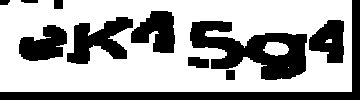

In [37]:
captcha = Image.open("test-01.png").convert("1")
parciais = []
mais_frequentes = []

parciais.append(obter_caracteres(captcha))

for _ in range(4):
    parciais.append(obter_caracteres(remover_ruidos(captcha)))

for _ in range(4):
    parciais.append(obter_caracteres(reforcar_tracos(captcha)))
    
for i in parciais:
    mais_frequentes.append(contar_caracteres(i))
    
pprint(mais_frequentes)
resultado(mais_frequentes)
captcha

## Onde estou?
- Blog [mrioqueiroz.com](https://mrioqueiroz.com)
- Nas redes sociais como [@mrioqueiroz](https://twitter.com/mrioqueiroz)